# Text Analytics: Sentiment Analysis of Products Review on Amazon

## Table of Contents

* [Libraries](#section1)
* [Dataset](#section1)

# Libraries <a class="anchor" id="section1"></a>

In [2]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
import sys
import wordcloud # pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
# from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import re

# sklearn
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV #, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# scipy
from scipy import interp

# imblearn
from imblearn.over_sampling import SMOTE # conda install -c conda-forge imbalanced-learn
# from imblearn.combine import SMOTETomek # pip install -U imbalanced-learn
from imblearn.pipeline import make_pipeline, Pipeline
# from imblearn.under_sampling import NearMiss

# Utility
import math
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle
from collections import Counter, defaultdict, Sequence
from itertools import cycle, combinations, chain
from IPython.display import clear_output

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset <a class="anchor" id="section2"></a>
[About dataset](https://www.kaggle.com/datasets/nehaprabhavalkar/indian-products-on-amazon)

In [3]:
data = pd.read_csv('../input/indian-products-on-amazon/amazon_vfl_reviews.csv' ,encoding='latin', names = ['asian','name','date','rating','text'], skiprows=1) # encoding="UTF-8". skiprows=1: Skips the first row from top in the csv file
data.head(3)

,asian,name,date,rating,text
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...


# Data size

In [4]:
reviewColName = 'text' # Better programming practice: The name of review column is stored in a variable, so that in other dataset with different column name it is only enough to change this variable
ratingColName = 'rating' # Better programming practice:
ratingOrigColName = ratingColName+'Orig'
clfParamName = 'clf' # common word used in param_grid & Pipeline
n_splits = 3 #4 Fold number in K-fold CV
n_repeats = 2 #10: Number of repetitions of cross-validation
random_state = 0
print('Rows nb: {}\nColumns nb: {}\nColumn names: {}'.format(data.shape[0], data.shape[1], (', ').join(list(data.columns)))) # Displays the size of the data

Rows nb: 2782
Columns nb: 5
Column names: asian, name, date, rating, text


# Data wrangling:
* Removing rows containing NA/NAN values;
* Removes non-word text tokens (HTML markup, emoticons, ...);
* Stem of text tokens;
* Removing stop-words text tokens.

In [5]:
def na_remover(dfIn):
    """Removes rows containing NA/NAN values"""
    dfOut = dfIn.dropna()
    print("{} rows containing NA/NAN were removed.".format(dfIn.shape[0] - dfOut.shape[0]))
    return dfOut


def nonWord_remover(textIn):
    """Removes non-word text tokens"""
    textOut = re.sub('<[^>]*>', '', textIn) # Removes all of the HTML markup from the reviews.
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', textOut) # Finds emoticons
    textOut = (re.sub('[\W]+', ' ', textOut.lower()) + ' '.join(emoticons).replace('-', '')) # Removes all non-word characters from the text via the regex [\W]+ and converts the text into lowercase characters.
    return textOut


porter = PorterStemmer()
def word_stemmer(textIn):
    """Stem of text tokens"""
    textOut = [porter.stem(word) for word in textIn.split()]
    return textOut


stopWords = stopwords.words('english')+['product', 'thi', 'à', 'the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
def stopWords_remover(textIn):
    """Removes stop-words text tokens"""
    textOut = ' '.join([word for word in textIn if word not in stopWords])
    return textOut


def mostCommonWords_finder(df, N, lenMin):
    """Finds the most common N words of minimum length of lenMin"""
    all_words = []
    for line in list(df):
        words = line.split()
        for word in words:
          if (len(word) > lenMin):
            all_words.append(word.lower()) 
    return Counter(all_words).most_common(N)


def wrangler(dfIn, textColumn):
    """Removes NA/NAN values & non-word & stop-words text tokens"""
    dfOut = na_remover(dfIn) # Removes rows containing NA/NAN values
    dfOut[textColumn] = dfOut[textColumn].apply(nonWord_remover) # Removes non-word text tokens
    dfOut[textColumn] = dfOut[textColumn].apply(word_stemmer) # Stem of text tokens
    dfOut[textColumn] = dfOut[textColumn].apply(stopWords_remover) # Removes stop-words text tokens
    return dfOut


def wordcloud_plotter(ax, data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    ax.axis('off')
    if title: 
        ax.set_title(title, fontsize = 20)
    ax.imshow(wordcloud)
  
    
dataCleaned = wrangler(data, reviewColName)

4 rows containing NA/NAN were removed.


# Word cloud before and after wrangling

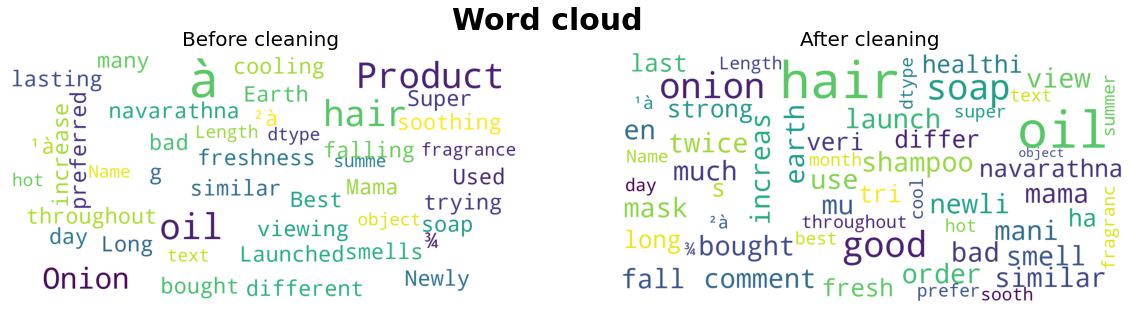

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5)) 
fig.suptitle('Word cloud', fontsize= 30, fontweight='bold')
wordcloud_plotter(axs[0], data[reviewColName], 'Before cleaning')
wordcloud_plotter(axs[1], dataCleaned[reviewColName], 'After cleaning')
plt.savefig("../working/wordCloud.png")

# All possible combinations of class merging and selection
* For each total number of N classes, i.e., 2, 3, 4, and 5, all possible N selection of classes from the original number of classes (5) has been considered:
 * E.g., for N = 3, some 3-class scenarios are:
      * [1, 2, 3], [1, 2, 4], [1, 2, 5], ...
* Also all possible merging of neighboring classes are considered:
 * E.g., for N = 3, some merged 3-class scenarios are (merged classes are enclosed in parentheses):
     * [(1,2), 3, 4], [1, (2, 3), 4], ... [(1,2,3), 4, 5], ...

In [7]:
# %matplotlib inline 
def class_chooser_helper(tmp, tmp2, clsNb = None):
    """A helper for class_chooser"""
    if clsNb != None:
        jj = clsNb
    elif clsNb == None:
        jj = range(2, len(tmp)+1)
    for j in jj:  
        tmp3 = list(combinations(tmp, j))
        for tmp4 in tmp3:
            tmp2.append(tmp4)
    return tmp2
  
    
def class_chooser(classLabel, clsNb = None):
    """Chooses possible combination of classes"""
    tmp2 = []
    tmp2 = class_chooser_helper(classLabel, tmp2, clsNb)
    for k in range(2,len(classLabel)):
        for i in range(0,len(classLabel)-k+1):
            tmp = []
            tmp.append((classLabel[i:i+k]))
            rest = set(classLabel)-set(classLabel[i:i+k])
            for tmp5 in rest:
                tmp.append(tmp5)
            tmp2 = class_chooser_helper(tmp, tmp2, clsNb)
    tmp2 = set(tmp2)
    classNb = defaultdict(list)
    for tmp in tmp2:
        classNb[len(tmp)].append(tmp)
    return classNb


def ismember(a, b): # https://devpress.csdn.net/python/630459aac67703293080ba45.html
    """Equivalent to MATLAB's ismember function"""
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = True
    return [bind.get(itm, False) for itm in a]  # None can be replaced by any other "not in b" value


def class_merger(dataCleaned, ratingColName, classes):
    addVal = 100 
    flattenedClass = []
    for i in classes:
        if isinstance(i, (Sequence, np.ndarray)): # https://stackoverflow.com/questions/16807011/python-how-to-identify-if-a-variable-is-an-array-or-a-scalar
            for j in i:
                flattenedClass.append(j)
        else:
            flattenedClass.append(i)
    selectedClassesIdx = ismember(dataCleaned[ratingColName], flattenedClass)
    dataCleanedMerged = dataCleaned.loc[selectedClassesIdx, :]
    dataCleanedMerged[ratingOrigColName] = dataCleaned[ratingColName]
    for newClass, oldClass in enumerate(classes):
        dataCleanedMerged = dataCleanedMerged.replace({ratingColName:oldClass}, newClass + addVal)
        dataCleanedMerged = dataCleanedMerged.replace({ratingOrigColName:oldClass}, str(oldClass))
    dataCleanedMerged[ratingColName] -= addVal
    return dataCleanedMerged


def nRowCol_calculator(subplotsNb, subplotsCols = 5):
    if len(subplotsNb) > subplotsCols:
        nCol = subplotsCols
        nRow = math.ceil(len(subplotsNb) / nCol)
    else:
        nCol = len(subplotsNb)
        nRow = 1 
    return nRow, nCol


def plot_parameters(axs, pltIdx, nRow, nCol):
    rows, cols = divmod(pltIdx, nCol) # https://stackoverflow.com/questions/28995146/matlab-ind2sub-equivalent-in-python
    if nRow != 1:
            ax = axs[rows, cols]
    elif nCol != 1:
        ax = axs[cols]
    elif nCol == 1:
        ax = axs    
    if rows+1 == nRow:
        isXlabel = True
    else:
        isXlabel = False
    if cols+1 == 1:
        isYlabel = True
    else:
        isYlabel = False
    return ax, isXlabel, isYlabel


def classSize_plotter(ax, isXlabel, isYlabel, df, df_col, df_colOrig):
    sns.countplot(ax=ax, x = df_col, hue=df_colOrig, data = df, dodge=False)
    if not isXlabel:
        ax.set_xlabel('')
    if not isYlabel:
        ax.set_ylabel('')

    
def classSizeTot_plotter(classNb, classNbIdx, dataCleaned, ratingColName):
    nRow, nCol = nRowCol_calculator(classNb[classNbIdx])    
    fig, axs = plt.subplots(nRow, nCol, figsize = (20, 4*nRow)) 
    fig.suptitle('Class size for {}-class classification task'.format(classNbIdx), fontsize= 30, fontweight='bold')
    for pltIdx, classes in enumerate(classNb[classNbIdx]):
        dataCleanedMerged = class_merger(dataCleaned, ratingColName, classes)
        ax, isXlabel, isYlabel = plot_parameters(axs, pltIdx, nRow, nCol)
        classSize_plotter(ax, isXlabel, isYlabel, dataCleanedMerged, ratingColName, ratingOrigColName)
    plt.savefig("../working/{}-classSize.png".format(classNbIdx))

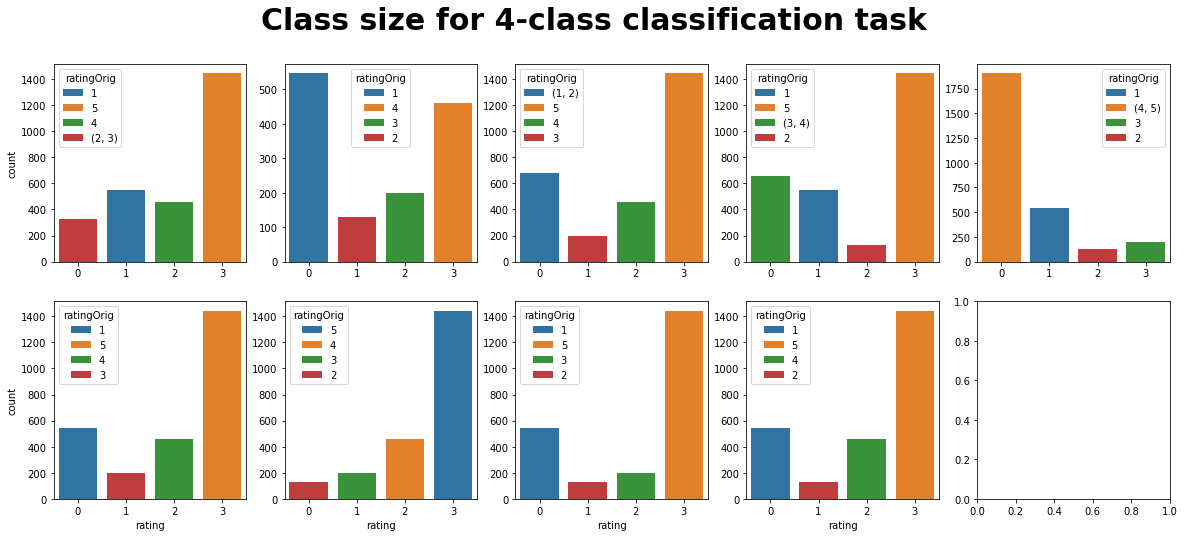

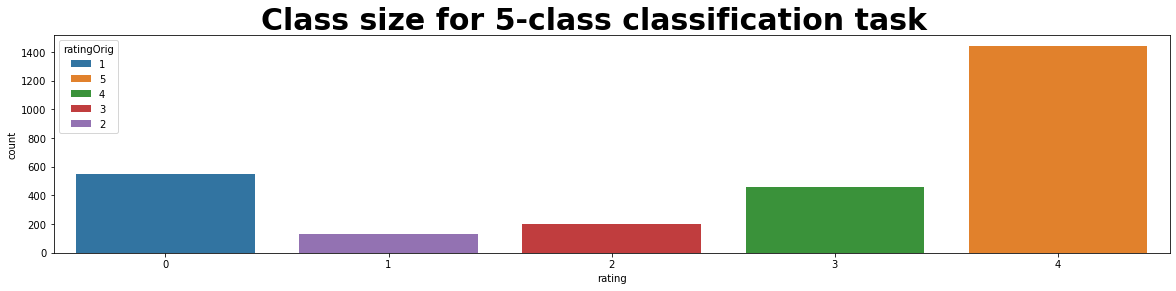

In [8]:
classLabel = tuple(np.unique(dataCleaned[ratingColName]))
classNb = class_chooser(classLabel, clsNb = [4, 5]) # Specify clsNb=None, for general case
for classNbIdx in classNb.keys():
    classSizeTot_plotter(classNb, classNbIdx, dataCleaned, ratingColName)

# Imbalanced (skewed) class size

In [9]:
def tfidf_instantiator(): 
    TfidfVectorizerParams = {'sublinear_tf':True, 'strip_accents':None, 'lowercase':False, 'preprocessor':None} # To meke sure the same TfidfVectorizer params are used across the code
    tfidf  = TfidfVectorizer(**TfidfVectorizerParams) # sublinear_tf=True
    return tfidf


def smote_instantiator(y): 
    """SMOTE value is equal to the maximum class size"""
    smoteClassSize = pd.Series(np.asarray(y)).value_counts(sort=True).iloc[0] # The resulting object will be in descending order so that the first element is the most frequently-occurring element.
    sampling_strategy = {}
    for i in np.unique(y):
        sampling_strategy[i] = smoteClassSize
    smote = SMOTE(random_state=random_state, sampling_strategy=sampling_strategy ) #  , k_neighbors = 3
    return smote


def clf_instantiator(clfName):    
    if clfName == "svm":
        clf = svm.SVC(kernel='linear', probability=True, random_state=random_state) 
        param_grid = "?"
    elif clfName == "knn":
        clf = KNeighborsClassifier() 
        param_grid = [{clfParamName+'__'+'n_neighbors': [3, 5, 7, 9],
                           clfParamName+'__'+'weights': ['uniform', 'distance'],
                           clfParamName+'__'+'p': [1, 2]}]
    elif clfName == "lr":
        clf = LogisticRegression(random_state=random_state) 
        param_grid = [{clfParamName+'__'+'penalty': ['l1', 'l2'],
                       clfParamName+'__'+'C': [10.0, 100.0]}] # 0.001, 0.01, 0.1, 1.0,
    elif clfName == "nb":
        clf = BernoulliNB() 
        param_grid = "?"
    return clf, param_grid


def model_builder(y, clfName, clfParamName):    
    tfidf = tfidf_instantiator()        
    smote = smote_instantiator(y)
    if type(clfName) == str: # Grid-search mode: instantiate clf
        clf, param = clf_instantiator(clfName)
    else: # uses previously-computed optimal clf
        clf, param = clfName, None
    model = Pipeline([('tfidf', tfidf), (clfParamName, clf)]) # , ('smote', smote)
    return model, param


def optClf_finder(clfNames, X, y):
    """Finds optimal clf and related params using gridSearchCV"""
    gridSearchCV = {}
    for clfName in clfNames:
#         tfidf = tfidf_instantiator()        
#         smote = smote_instantiator(y)
#         clf, param = clf_instantiator(clfName)
#         model = Pipeline([('tfidf', tfidf), (clfParamName, clf)]) # , ('smote', smote)
        model, param = model_builder(y, clfName, clfParamName)
        gs = GridSearchCV(model, param, scoring='accuracy', cv=n_splits, verbose=2, n_jobs=-1)
        gs.fit(X, y)
        gridSearchCV[clfName] = [gs.best_params_, gs.best_score_]
        print('Best parameter set: {}'.format(gs.best_params_))
        print('CV Accuracy: {}'.format(gs.best_score_))
    acc = []
    for val in gridSearchCV.values():
        acc.append(val[1])
    optClfAcc = np.max(acc)
    optClfName = clfNames[np.argmax(acc)] # Index of classifier with maximum performance in grid search
    optParam = gridSearchCV[optClfName][0]
    optParam2 = {}
    for key, val in optParam.items():
        optParam2[key[len(clfParamName)+2:]] = val
    optClf, _ = clf_instantiator(optClfName) # instantiate the optimal clf
    optClf.set_params(**optParam2) # set the optimal params
    print('optimal clf is {}.'.format(optClfName))
    clear_output(wait=False)
    return optClf, optClfName, optClfAcc

In [10]:
# smote_instantiator(dataCleaned[ratingColName])
# # acc = []
# # for val in gridSearchCV.values():
# #     acc.append(val[1])
# optIdx = np.argmax(acc) # Index of classifier with maximum performance in grid search
# # optParam = gridSearchCV[optIdx][0]
# # # optClf = clfs[optIdx]
# # # optName = names[optIdx]
# # print(optParam)
# clfNames[optIdx]
# # clf = clf_instantiator(clfNames[optIdx])
# optClf

In [11]:
# data2 = data1.dropna(axis = 0)
# data2.isnull().sum()
# data2.head()
# clf.penalty

In [12]:
# print('Rows number for the original data: {}'.format(data.shape[0])) 
# print('Rows number for the re-sampled data (sampling fraction = {}): {}'.format(frac, data1.shape[0])) 
# print('Rows number for the null-row-removed data: {}'.format(data2.shape[0])) 

In [13]:
# rating = pd.DataFrame(data2['rating'].value_counts().reset_index()) # QUESTION: What is the point in applying 'reset_index()' method? Because in the next line 'sort_values' will destroy the index order 
# rating.columns = ['rating', 'count']

# rating.sort_values('rating', ascending= False, inplace= True)
# rating

# Convert the review rating from int64 to int32 

In [14]:
def gridSearch_plotter(optClasses, optClfsName, optClfsAcc, classNbIdx):
    xtickLabel = []
    for i, j in zip(optClasses, optClfsName):
        xtickLabel.append(str(i) + '-' + j)     
    fig, _ = plt.subplots(1, 1, figsize = (20, 4)) 
    fig.suptitle('Grid search accuracy (cv={}) for {}-class classification tasks'.format(n_splits, classNbIdx), fontsize= 30, fontweight='bold')
    plt.plot(optClfsAcc, 'o-')
    plt.xticks(np.arange(len(optClfsAcc)), xtickLabel, rotation=30)
    plt.ylabel('Accuracy')
    plt.xlabel('Optimum classifier per class merging')
    plt.grid()
    plt.savefig("../working/{}-GridSearchAcc.png".format(classNbIdx))     

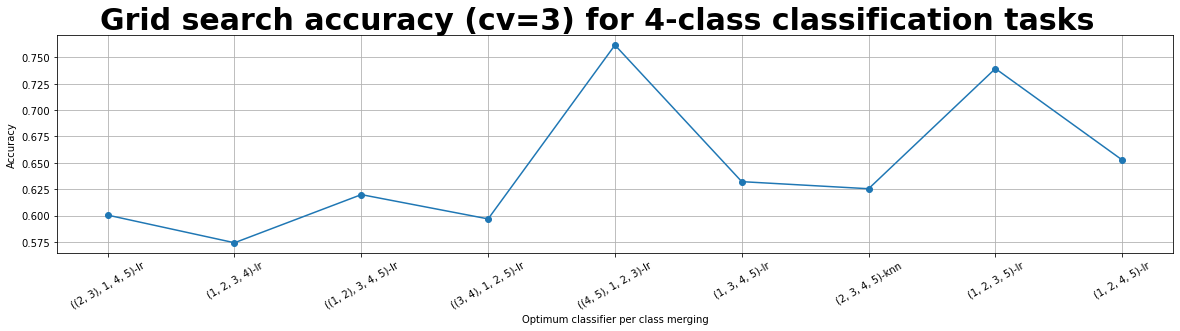

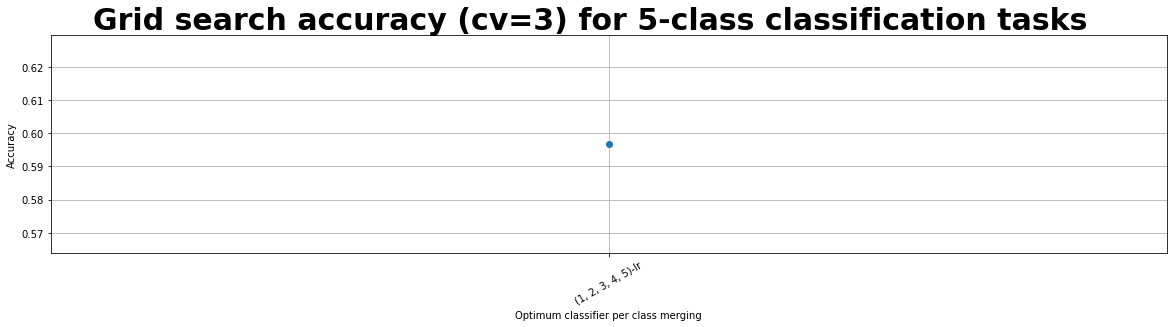

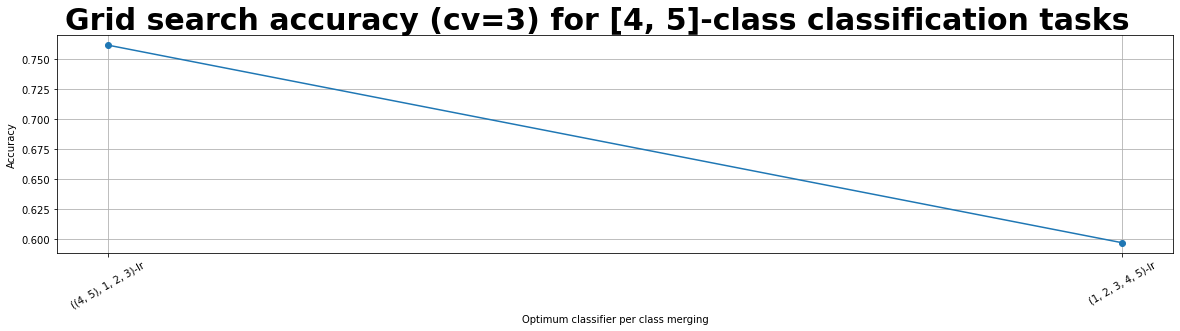

In [15]:
clfNames = ['knn', 'lr']
optClfs = defaultdict(list)
optClfsName = defaultdict(list)
optClasses = defaultdict(list)
optClfsAcc = defaultdict(list)
dataCleanedMerged = defaultdict(list)
for classNbIdx in classNb.keys():
    for classes in classNb[classNbIdx]:
        dataMerged = class_merger(dataCleaned, ratingColName, classes)
        dataCleanedMerged[classNbIdx].append(dataMerged)
        optClf, optClfName, optClfAcc = optClf_finder(clfNames, dataMerged[reviewColName], dataMerged[ratingColName])
        optClfs[classNbIdx].append(optClf)
        optClfsName[classNbIdx].append(optClfName)
        optClasses[classNbIdx].append(classes)
        optClfsAcc[classNbIdx].append(optClfAcc)    
  

optDataCleanedMerged = []
optClf = []
optClfName = []
optClass = []
optClfAcc = []
for classNbIdx in classNb.keys():   
    gridSearch_plotter(optClasses[classNbIdx], optClfsName[classNbIdx], optClfsAcc[classNbIdx], classNbIdx)    
    optIdx = np.argmax(optClfsAcc[classNbIdx]) # Maximum acc idx across different combinations of the classNbIdx-class classification task
    optDataCleanedMerged.append(dataCleanedMerged[classNbIdx][optIdx])
    optClf.append(optClfs[classNbIdx][optIdx])
    optClfName.append(optClfsName[classNbIdx][optIdx])
    optClass.append(optClasses[classNbIdx][optIdx])
    optClfAcc.append(optClfsAcc[classNbIdx][optIdx])

gridSearch_plotter(optClass, optClfName, optClfAcc, str(list(classNb.keys())))

In [16]:
# data4.describe()
# ('-').join(str(list(classNb.keys())))
# str(list(classNb.keys()))
# dataCleanedMerged

# Class (positive, neutral, negative) size

In [17]:
# print('3-class size: {}'.format(data4.shape[0])) 
# print('Positve class size: {}'.format(len(data4['rating'][data4.rating == 1 ])))
# print('Neutral class size: {}'.format(len(data4['rating'][data4.rating == 0 ])))
# print('Negative class size: {}'.format(len(data4['rating'][data4.rating == -1 ])))

# Word count per review

In [18]:
# def word_count(words):
#     return len(words.split())

In [19]:
# data4['word count'] = data4['text'].apply(word_count)
# p = data4['word count'][data4.rating == 1]
# m = data4['word count'][data4.rating == 0]
# n = data4['word count'][data4.rating == -1]
# plt.figure(figsize=(12,6)) 
# plt.xlim(0,200)
# plt.xlabel('Word count')
# plt.ylabel('Frequency')
# g = plt.hist([p,m,n], color=['g','r','b'], alpha=0.5, label=['Positive','Neutral','Negative'])
# plt.legend(loc='upper right')

# Common words

In [20]:
# all_words = []
# for line in list(dataCleaned['text']):
#     words = line.split()
#     for word in words:
#       if (len(word)>2):
#         all_words.append(word.lower())
    
    
# Counter(all_words).most_common(20)
# mostCommonWords_finder(dataCleaned['text'], 20, 2)

# Data processing

# Convrting review type from object to string

In [21]:
# data5['text'] = data5['text'].astype('str') # NOTICE: Not clear. What is the purpose?
# data5.dtypes

# Download 'stopwords', 'punkt', and 'wordnet' packages

In [22]:
# nltk.download('stopwords')
# stopword = set(stopwords.words('english'))
# nltk.download('punkt')
# nltk.download('wordnet')

# Clean text: remove non-word, punctuations, stopwords, ...

In [23]:
# def cleanText(input_string):
#     modified_string = re.sub('[^A-Za-z0-9]+', ' ', input_string)
#     return(modified_string)

# def cleanText_v2(text): # SOURCE: Chapter 8 of the book: Python Machine Learning: Machine Learning and Deep Learning with Python
#     text = re.sub('<[^>]*>', '', text) # Removes all of the HTML markup from the reviews.
#     emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # Finds emoticons
#     text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')) # Removes all non-word characters from the text via the regex [\W]+ and converts the text into lowercase characters.
#     return text

# data5['clean_review_text'] = data5.text.apply(cleanText)
# data5['clean_review_text'][150]

In [24]:
# data5['clean_review_text']=data5['clean_review_text'].str.lower() # converting to lower case
# data5['clean_review_text']=data5['clean_review_text'].str.translate(str.maketrans('','',string.punctuation)) # removing punctuations

In [25]:
# stopWords=stopwords.words('english')+['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
# def removeStopWords(stopWords, rvw_txt):
#     newtxt = ' '.join([word for word in rvw_txt.split() if word not in stopWords])
#     return newtxt
# data5['clean_review_text'] = [removeStopWords(stopWords,x) for x in data5['clean_review_text']]

# Tokeniza - lemmatize

In [26]:
# def process_tweets(tweet):    
#     tokens = word_tokenize(tweet) # tokenizing words    
#     final_tokens = [w for w in tokens if w not in stopword] # #Removing Stop Words. NOTICE: We had removed stopwords before in [184], so this line is extra
#     wordLemm = WordNetLemmatizer() # reducing a word to its word stem
#     finalwords = []
#     for w in final_tokens:
#       if len(w)>1:
#         try:
#             w = wordLemm.lemmatize(w)  
#         except:
#             pass
#         finalwords.append(w)
#     return ' '.join(finalwords)

# data5['final text'] = data5['clean_review_text'].apply(lambda x: process_tweets(x))
# data5.head(10)

# Word cloud

In [27]:
# def show_wordcloud(ax, data, title = None):
#     wordcloud = WordCloud(
#         background_color = 'white',
#         max_words = 200,
#         max_font_size = 40, 
#         scale = 3,
#         random_state = 42
#     ).generate(str(data))

#     ax.axis('off')
#     if title: 
#         ax.set_title(title, fontsize = 20)
#     ax.imshow(wordcloud)

# fig, axs = plt.subplots(1, 2, figsize = (20, 5)) 
# fig.suptitle('Word cloud', fontsize= 30, fontweight='bold')
# show_wordcloud(axs[0], data["text"], 'Before cleaning')
# show_wordcloud(axs[1], data5["final text"], 'After cleaning')
# plt.savefig("results/wordCloud.png")

# Imbalanced (skewed) class size

In [28]:
# %matplotlib inline
# sns.countplot(x='rating', hue='rating', data = data5, dodge=False)
# plt.suptitle('Class size', fontweight='bold')
# plt.savefig("results/classSize.png")

In [29]:
# # # X = data5['final text'].values
# # # Y = data5['rating'].values
# # Xtxt = dataCleaned[reviewColName].values
# # Ytxt = dataCleaned[ratingColName].values
# Xtxt = optDataCleanedMerged[0][reviewColName].values
# Ytxt = optDataCleanedMerged[0][ratingColName].values
# classLabel = list(np.unique(Ytxt))
# # Xtxt = dataCleaned[reviewColName]
# # Ytxt = dataCleaned[ratingColName]
# # # Xtxt = X.copy()
# # # Ytxt = Y.copy()
# # print(Xtxt.shape)
# # print(Ytxt.shape)
# # len(optDataCleanedMerged)
# # classLabel = list(np.unique(Ytxt))

# Processing
* Evaluation strategy: N*K-fold Cross Validation (CV)
* Feature: TF-IDF vectorization
* Feature oversampling: Synthetic Minority Oversampling Technique (SMOTE)
* Classifiers: Naive Bayes (NB), Logistic Regression (LR), and Support Vector Machine (SVM, Linear)
* Validation metrics: 
 * One-vs-Rest (OvR) binary Receiver Operating Characteristic (ROC) curve + their macro-average across repetitions;
 * Area under the ROC Curve (AUC);
 * G-mean;
 * True Positive Rate (TPR), Positive Predictive Value (PPV), Accuracy (ACC);
 * One-vs-Rest (OvR) binary confusion matrix;
 * Multiclass (3) confusion matrix.

In [30]:
# classLabel = np.unique(Ytxt)
# classLabel[0]
# len(classLabel)
# list(np.unique(Ytxt))

In [31]:
# optClf, optClfName
# def split_feature_clf_cv(X, y, clf, n_splits, n_repeats):
#     """Splits into train/test; extracts features; trains & tests the classifier using N*K-fold cross-validation. Returns average test accuracy."""
#     cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state) 
#     acc, fpr, tpr, thr = [], [], [], []
#     for train_index, test_index in cv.split(X, y): # 0<k<(n_repeats*n_splits-1)
#         X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index] # train/test split
#         model, _ = model_builder(y_train, clf, '')
#         model.fit(X_train, y_train)                 
#         if len(np.unique(y)) == 2: # If binary task  
#             y_score = model.predict_proba(X_test)[:, 1]
#             fpr_, tpr_, thr_ = roc_curve(y_test, y_score) 
#         else:
#             fpr_, tpr_, thr_ = np.nan, np.nan, np.nan
#         acc.append(model.score(X_test, y_test)) # Classifier acc 
#         fpr.append(fpr_)
#         tpr.append(tpr_)
#         thr.append(thr_)
#     return acc, fpr, tpr, threshold

# acc,_,_,_ = split_feature_clf_cv(Xtxt, Ytxt, optClf[0], n_splits, n_repeats)


In [32]:
# clfIni == optClf #[0.9384449244060475, 0.9514038876889849, 0.927645788336933, 0.9395248380129589, 0.9395248380129589, 0.9449244060475162]

In [33]:
# n_classes

# ROC

In [34]:
def output_binariser(X, Y, classLabel):
    """Binarize the output"""
    y_binary = label_binarize(Y, classes=classLabel)

    X_binary = []
    Y_binary = []
    for i in range(y_binary.shape[1]): 
        Xrsmp, Yrsmp = X, y_binary[:, i]
        X_binary.append(Xrsmp)
        Y_binary.append(Yrsmp)
    return X_binary, Y_binary


def idx_finder_micro(classNb):
    idx = []
    for i in range(n_repeats*n_splits):
        idx.append(np.asarray(list(range((classNb-1)*X_test.shape[0], classNb*X_test.shape[0]))) + i * (n_classes-1)*X_test.shape[0])
    idx = np.hstack(idx)
    return idx


def fpr_unique_finder(n_classes, classNb, fpr_all):
    idx = list(range((classNb-1), n_classes * n_repeats*n_splits, n_classes))
    fprSel = []
    for i in idx:
        fprSel.append(fpr_all[i])
    fprUnique = np.unique(np.concatenate(np.asarray(fprSel)))
    return fprUnique


def microAvg_calc(n_classes, y_test_all_ravel, y_score_all):
    # Compute micro-average ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        micro_tmp = "micro_{}".format(i+1)
        fpr[micro_tmp], tpr[micro_tmp], _ = roc_curve(y_test_all_ravel[idx_finder_micro(i+1)], y_score_all[idx_finder_micro(i+1)])
        roc_auc[micro_tmp] = auc(fpr[micro_tmp], tpr[micro_tmp])  
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_all_ravel, y_score_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc


def roc_bestThr(tpr, fpr, thr, fieldName):
#     https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    roc_auc = {}
    gmeans = np.sqrt(tpr * (1-fpr)) # calculate the g-mean for each threshold
    roc_auc["{}BestThrIdx".format(fieldName)] = np.argmax(gmeans) # locate the index of the largest g-mean
    roc_auc["{}BestThrVal".format(fieldName)] = thr[roc_auc["{}BestThrIdx".format(fieldName)]] 
    roc_auc["{}BestThrGmeans".format(fieldName)] = gmeans[roc_auc["{}BestThrIdx".format(fieldName)]]
    return roc_auc


def macroAvg_calc(n_classes, n_repeats, n_splits, fpr_all, fpr, tpr, thresholds):
    # First aggregate all false positive rates
    fpr_unique_perClass = []
    for i in range(n_classes):
        fpr_unique_perClass.append(fpr_unique_finder(n_classes, i+1, fpr_all))  

    fpr_unique = np.unique(np.concatenate(fpr_all))

    # Then interpolate all ROC curves at this points
#     mean_tpr_perClass = {0: np.zeros_like(fpr_unique_perClass[0]), 1: np.zeros_like(fpr_unique_perClass[1]), 2: np.zeros_like(fpr_unique_perClass[2])}
    mean_tpr_perClass = {}
    for j in range(n_classes):
        mean_tpr_perClass[j] = np.zeros_like(fpr_unique_perClass[j])
    mean_tpr = np.zeros_like(fpr_unique)
#     mean_thr_perClass = {0: np.zeros_like(fpr_unique_perClass[0]), 1: np.zeros_like(fpr_unique_perClass[1]), 2: np.zeros_like(fpr_unique_perClass[2])}
    mean_thr_perClass = {}
    for j in range(n_classes):
        mean_thr_perClass[j] = np.zeros_like(fpr_unique_perClass[j])
    mean_thr = np.zeros_like(fpr_unique)
    for i in range(n_classes):
        for j in range(n_repeats*n_splits):
            mean_tpr += interp(fpr_unique, fpr[i][j], tpr[i][j])
            mean_tpr_perClass[i] += interp(fpr_unique_perClass[i], fpr[i][j], tpr[i][j])
            mean_thr += interp(fpr_unique, fpr[i][j], thresholds[i][j])
            mean_thr_perClass[i] += interp(fpr_unique_perClass[i], fpr[i][j], thresholds[i][j])
    # Finally average it and compute AUC
    mean_tpr /= (n_classes * n_repeats*n_splits)
    mean_thr /= (n_classes * n_repeats*n_splits)
    for i in range(n_classes):
        mean_tpr_perClass[i] /= (n_repeats*n_splits)
        mean_thr_perClass[i] /= (n_repeats*n_splits)

    roc_auc = dict()
    for i in range(n_classes):
        macro_tmp = "macro_{}".format(i+1)                         
        fpr[macro_tmp], tpr[macro_tmp] = np.hstack([0, fpr_unique_perClass[i], 1]), np.hstack([0, mean_tpr_perClass[i], 1])
        
        roc_auc_ = roc_bestThr(tpr[macro_tmp], fpr[macro_tmp], mean_thr_perClass[i], macro_tmp)
        roc_auc.update(roc_auc_)
    
        roc_auc[macro_tmp] = auc(fpr[macro_tmp], tpr[macro_tmp])

    fpr["macro"], tpr["macro"] = np.hstack([0, fpr_unique, 1]), np.hstack([0, mean_tpr, 1])
    roc_auc_ = roc_bestThr(tpr["macro"], fpr["macro"], mean_thr, "macro")
    roc_auc.update(roc_auc_)
    
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])                                 
    return fpr, tpr, roc_auc                             


# def model_fit_cv(X, y_binary, classifier):
#     rowNb = equalClassSize * 2
# #     rowNb = 100
#     classifierIni = classifier
#     y_score_svm = np.array([np.ones((rowNb, len(y_binary)))*10] * n_splits * n_repeats)  #list() # []
#     y_test_all = np.array([np.ones((rowNb, len(y_binary)))*10] * n_splits * n_repeats) # n_splits * n_repeats x rowNb x len(y_binary)
# #     print(np.shape(y_test_all))
# #     print(np.shape(y_score_svm))
#     for i in range(len(y_binary)): 
#         cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state) # 
#         for k, (train_index, test_index) in enumerate(cv.split(X[i], y_binary[i])):
#             X_train, X_test = X[i][train_index], X[i][test_index]
#             y_train, y_test = y_binary[i][train_index], y_binary[i][test_index]  
# #             print(len(np.unique(y_train)))
#             vector = TfidfVectorizer(sublinear_tf=True)
#             X_train = vector.fit_transform(X_train)
#             X_test = vector.transform(X_test)
    
#             smote = SMOTE(random_state=random_state, sampling_strategy={0:equalClassSize, 1:equalClassSize}) # 
#             X_train, y_train = smote.fit_resample(X_train, y_train)

#             smote = SMOTE(random_state=random_state, sampling_strategy={0:equalClassSize, 1:equalClassSize})
#             X_test, y_test = smote.fit_resample(X_test, y_test)
    
#             classifier = classifierIni
# #             print(classifier)
#             y_score = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1] # decision_function
# #             print(np.shape(y_score))
#             y_score_svm[k][:, i] = y_score
#             y_test_all[k][:, i] = y_test
   
#     return y_score_svm, y_test_all#, test_indexAll


# def split_feature_clf_cv(X, y, clf, n_splits, n_repeats):
#     """Splits into train/test; extracts features; trains & tests the classifier using N*K-fold cross-validation. Returns average test accuracy."""
#     cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state) # 
#     acc = []
#     for train_index, test_index in cv.split(X, y): # 0<k<(n_repeats*n_splits-1)
#         X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index] # train/test split
# #         tfidf = TfidfVectorizer(**TfidfVectorizerParams) # Feature extraction
# #         model = Pipeline([('tfidf', tfidf), ('clf', clf)]).fit(X_train, y_train) 
#         model, _ = model_builder(y, clf, clfParamName)
#         model.fit(X_train, y_train) 
#         acc.append(model.score(X_test, y_test)) # Classifier score        
#         if len(np.unique(Ytxt)) == 2: # If binary task
#             y_score = model.predict_proba(X_test)[:, 1]
#             fpr, tpr, threshold = roc_curve(y_test, y_score) 
#         else:
#             fpr, tpr, threshold = np.nan, np.nan, np.nan
#     return np.mean(acc), fpr, tpr, threshold


# def fpr_tpr_roc_auc_initialiser(n_classes):
# # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     thresholds = dict()

#     for i in range(n_classes):
#         fpr[i] = []
#         tpr[i] = []
#         roc_auc[i] = []
#         thresholds[i] = []
#     return  fpr, tpr, roc_auc, thresholds                            


# def fpr_tpr_roc_auc_calc(n_classes, fpr, tpr, roc_auc, thresholds, y_score_svm, y_test_all):
#     y_score_all = [] # For Micro-average
#     y_test_all_ravel = [] # For Micro-average
#     fpr_all = []
#     for y_score, y_test in zip(y_score_svm, y_test_all):
#         y_score_all.append(y_score.ravel())
#         y_test_all_ravel.append(y_test.ravel())
        
#         for i in range(n_classes):
#             fpr_, tpr_, thresholds_ = roc_curve(y_test[:, i], y_score[:, i])
#             fpr_all.append(fpr_)
#             fpr[i].append(fpr_)
#             tpr[i].append(tpr_)
#             auc_ = auc(fpr_, tpr_)
#             roc_auc[i].append(auc_)
#             thresholds[i].append(thresholds_)

#     y_score_all = np.hstack(y_score_all)
#     y_test_all_ravel = np.hstack(y_test_all_ravel)
#     return fpr_all, fpr, tpr, roc_auc, thresholds, y_score_all, y_test_all_ravel

In [35]:
# optClf

In [36]:
# Xtxt = optDataCleanedMerged[0][reviewColName].values
# Ytxt = optDataCleanedMerged[0][ratingColName].values
# classLabel = list(np.unique(Ytxt))

# # random_state = 1 # np.random.RandomState(0)
# # n_repeats = 10 #10: Number of repetitions of cross-validation
# # n_splits = 4 #4
# n_classes = len(classLabel)
# # classLabel = list(np.unique(Ytxt))

# X_binary, Y_binary = output_binariser(Xtxt, Ytxt, classLabel)
# model_svm = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
#                                  random_state=random_state)) # create model
# model_lr = OneVsRestClassifier(LogisticRegression(random_state=random_state)) # create model
# model_nb = OneVsRestClassifier(BernoulliNB()) # create model
# optClf, optClfName
# optClfOvR = OneVsRestClassifier(optClf[0]) #  *********************

# models = {'Naive Bayes (NB)' : model_nb} #  , 'Logistic Regression (LR)' : model_lr, 'Support vector Machine (SVM)' : model_svm
models_name_abbrv = ['NB', 'LR', 'SVM']
colors_models = ['r', 'g', 'b', 'm', 'c'] 

colors_classes = ['r', 'g', 'b','m', 'c']
colors_classes_CF = ['Reds', 'Greens', 'Blues', 'copper', 'Blues'] 

n_models = 1 #len(models)

# equalClassSize = 2000

# fig, ax = plt.subplots(n_models+1, n_classes+1, figsize=(16,4*(n_models+1)), sharey=True, sharex=True)
# fig.suptitle('Multi-class ROC averaged on {}*{}-fold Cross-validation performance evaluation technique'.format(n_repeats, n_splits), 
#             fontsize=20, fontweight='bold')  
# lw = 2
    
# fpr_models = dict()
# tpr_models = dict()  

# for k, (model_name, classifier) in enumerate(models.items()):
 
#     y_score_svm, y_test_all= model_fit_cv(X_binary, Y_binary, classifier) 

# Visualisation

In [37]:
# def rocTot_plotter(optDataCleanedMerged, reviewColName, ratingColName, clfName, clf):
#     Xtxt = optDataCleanedMerged[reviewColName].values
#     Ytxt = optDataCleanedMerged[ratingColName].values
#     classLabel = list(np.unique(Ytxt))    
#     X_binary, Y_binary = output_binariser(Xtxt, Ytxt, classLabel)
#     n_classes = len(classLabel)
#     clf = OneVsRestClassifier(clf)
#     # fig, ax = plt.subplots(n_models, n_classes+1, figsize=(20,5*(n_models)), sharey=True, sharex=True)
#     fig, ax = plt.subplots(1, n_classes+1, figsize=(20,5), sharey=True, sharex=True)
#     fig.suptitle('Multi-class ROC averaged on {}*{}-fold Cross-validation performance evaluation technique'.format(n_repeats, n_splits), 
#                 fontsize=20, fontweight='bold')  
#     lw = 2    
#     fpr_models = [] #dict()
# #     tpr_models = dict()  
#     # for k, (model_name, clf) in enumerate(models.items()):

#     y_score_svm, y_test_all= model_fit_cv(X_binary, Y_binary, clf) 

#     fpr, tpr, roc_auc, thresholds = fpr_tpr_roc_auc_initialiser(n_classes)    

#     fpr_all, fpr, tpr, roc_auc, thresholds, y_score_all, y_test_all_ravel = fpr_tpr_roc_auc_calc(n_classes, fpr, tpr, roc_auc, thresholds, y_score_svm, y_test_all)

#     fpr_macro, tpr_macro, roc_auc_macro = macroAvg_calc(n_classes, n_repeats, n_splits, fpr_all, fpr, tpr, thresholds)                            
#     fpr.update(fpr_macro)
#     tpr.update(tpr_macro)
#     roc_auc.update(roc_auc_macro)

#     # Plot all ROC curves  
#     for i in range(n_classes):
#         for j in range(n_repeats*n_splits):
#             if j == 1:
#                 ax[i].plot(fpr[i][j], tpr[i][j], color=colors_classes[i], lw=lw, label='Classes {}'.format(classLabel[i]), alpha=1) # 
#             ax[i].plot(fpr[i][j], tpr[i][j], color=colors_classes[i], lw=lw) # , alpha=0.5

#         ax[i].plot(fpr["macro_{}".format(i+1)], tpr["macro_{}".format(i+1)], 'k', lw=lw, label='Macro-avg (AUC = {0:0.2f})'
#                      .format(roc_auc["macro_{}".format(i+1)]))
#         ax[i].scatter(fpr["macro_{}".format(i+1)][roc_auc["macro_{}BestThrIdx".format(i+1)]], 
#                          tpr["macro_{}".format(i+1)][roc_auc["macro_{}BestThrIdx".format(i+1)]], 
#                          marker='o', color='k', s=2**7, zorder=20,
#                         label='Opt (GM = {0:0.2f})'.format(roc_auc["macro_{}BestThrGmeans".format(i+1)]))
#         ax[i].axis('square')
#         ax[i].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
#         ax[i].axis([-0.05, 1.0, 0.0, 1.05])
# #         if i == 0:
# #             ax[i].set_ylabel('{} \n True Positive Rate (TPR)'.format(model_name), fontsize=12)
#         ax[i].set_ylabel('{} \n True Positive Rate (TPR)'.format(clfName), fontsize=12)
# #         if k == 0:
# #             theRest = classLabel.copy()
# #             theRest.pop(i)
# #             ax[i].set_title ("Binary task (OvR) \n Positive class label : {} \n Negative class labels : {}, {}".format(classLabel[i], theRest[0], theRest[1]), 
# #                                 fontdict = {'size':12}) # , pad = 20    
#         theRest = classLabel.copy()
#         theRest.pop(i)
#         ax[i].set_title ("Binary task (OvR) \n Positive class label : {} \n Negative class labels : {}, {}".format(classLabel[i], theRest[0], theRest[1]), 
#                             fontdict = {'size':12}) # , pad = 20 
#         ax[i].legend(loc="lower right")
#         ax[i].grid()

#     for i in range(n_classes):
#         ax[n_classes].plot(fpr["macro_{}".format(i+1)], tpr["macro_{}".format(i+1)], colors_classes[i], lw=lw, 
#                    label='Class {0} (AUC = {1:0.2f})'
#                      .format(classLabel[i], roc_auc["macro_{}".format(i+1)]))        
#     ax[n_classes].plot(fpr["macro"], tpr["macro"], 'k', lw=lw, label='Macro-avg (AUC = {0:0.2f})'
#                      .format(roc_auc["macro"]))
#     ax[n_classes].scatter(fpr["macro"][roc_auc["macroBestThrIdx"]], 
#                          tpr["macro"][roc_auc["macroBestThrIdx"]], 
#                          marker='o', color='k', s=2**7, zorder=20,
#                             label='Opt (GM = {0:0.2f})'.format(roc_auc["macroBestThrGmeans"]))
#     ax[n_classes].axis('square')
#     ax[n_classes].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
#     ax[n_classes].axis([-0.05, 1.0, 0.0, 1.05])
# #     if k == len(models):
# #         ax[n_classes].set_xlabel('False Positive Rate (FPR)', fontsize=12)
#     ax[n_classes].set_xlabel('False Positive Rate (FPR)', fontsize=12)
# #     if k == 0:
# #         ax[n_classes].set_title('Across classes', fontsize=12)
#     ax[n_classes].set_title('Across classes', fontsize=12)
#     ax[n_classes].legend(loc="lower right")
#     ax[n_classes].grid()

# #     fpr_models[model_name] = (fpr, tpr, roc_auc)
#     fpr_models = [(fpr, tpr, roc_auc)]

#     # for i in range(n_classes):
#     #     for j, model_name in enumerate(models.keys()):
#     #         ax[n_models, i].plot(fpr_models[model_name][0]["macro_{}".format(i+1)], 
#     #                              fpr_models[model_name][1]["macro_{}".format(i+1)], 
#     #                       color=colors_models[j], lw=lw, label='{0} (AUC={1:0.2f}, GM={2:0.2f})'
#     #                      .format(models_name_abbrv[j], fpr_models[model_name][2]["macro_{}".format(i+1)], fpr_models[model_name][2]["macro_{}BestThrGmeans".format(i+1)]))
#     #         ax[n_models, i].scatter(fpr_models[model_name][0]["macro_{}".format(i+1)][fpr_models[model_name][2]["macro_{}BestThrIdx".format(i+1)]], 
#     #                          fpr_models[model_name][1]["macro_{}".format(i+1)][fpr_models[model_name][2]["macro_{}BestThrIdx".format(i+1)]], 
#     #                          marker='o', color=colors_models[j], s=2**7, zorder=20), #label='Best {}'.format(models_name_abbrv[j])

#     #     ax[n_models, i].axis('square')
#     #     ax[n_models, i].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
#     #     ax[n_models, i].axis([-0.05, 1.0, 0.0, 1.05])  
#     #     ax[n_models, i].set_xlabel('False Positive Rate (FPR)', fontsize=12)
#     #     if i == 0:
#     #         ax[n_models, i].set_ylabel('Across models \n True Positive Rate (TPR)', fontsize=12)
#     #     ax[n_models, i].legend(loc="lower right")   
#     #     ax[n_models, i].grid()

#     # for i, model_name in enumerate(models.keys()):
#     #     ax[n_models, n_classes].plot(fpr_models[model_name][0]["macro"], fpr_models[model_name][1]["macro"], color=colors_models[i], 
#     #                   lw=lw, label='{0} (AUC={1:0.2f}, GM={2:0.2f})'
#     #                      .format(models_name_abbrv[i], fpr_models[model_name][2]["macro"], fpr_models[model_name][2]["macroBestThrGmeans"]))
#     #     ax[n_models, n_classes].scatter(fpr_models[model_name][0]["macro"][fpr_models[model_name][2]["macroBestThrIdx"]], 
#     #                                     fpr_models[model_name][1]["macro"][fpr_models[model_name][2]["macroBestThrIdx"]], 
#     #                          marker='o', color=colors_models[i], s=2**7, zorder=20) #, #label='Best {}'.format(models_name_abbrv[i])

#     # ax[n_models, n_classes].axis('square')
#     # ax[n_models, n_classes].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
#     # ax[n_models, n_classes].axis([-0.05, 1.0, 0.0, 1.05])
#     # ax[n_models, n_classes].set_xlabel('False Positive Rate (FPR)', fontsize=12)
#     # ax[n_models, n_classes].legend(loc="lower right") 
#     # ax[n_models, n_classes].grid()
#     plt.savefig("../working/ROC.png")
#     return fpr_models

# fpr_models = []
# for dataCleanedMergedTmp, classTmp, clfName, clf in zip(optDataCleanedMerged, optClass, optClfName, optClf):
#     fpr_model = rocTot_plotter(dataCleanedMergedTmp, reviewColName, ratingColName, str(classTmp)+'-'+clfName, clf)
#     fpr_models.append(fpr_model)
    
# # fpr_model = rocTot_plotter(optDataCleanedMerged[1], reviewColName, ratingColName, optClfName[1], optClf[1])

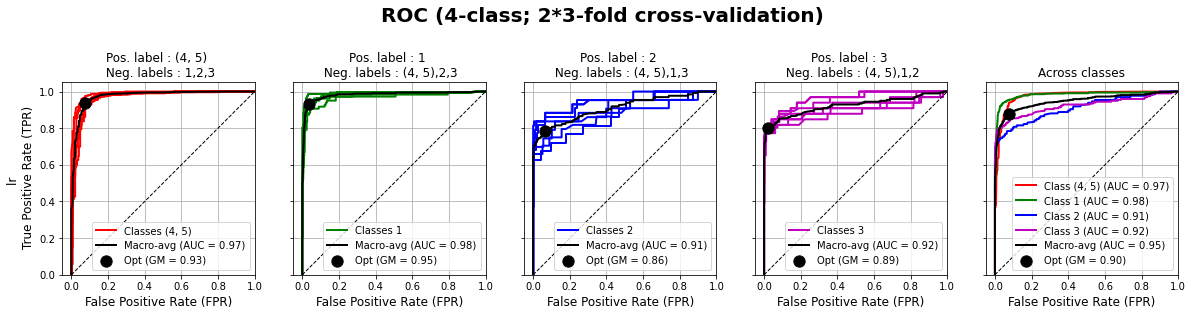

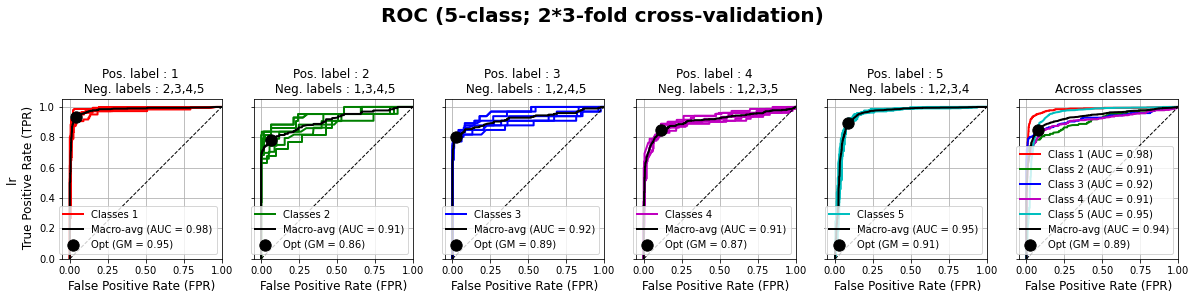

In [43]:
lw = 2 # Line width
def split_feature_clf_cv(X, y, clf, n_splits, n_repeats):
    """Splits into train/test; extracts features; trains & tests the classifier using N*K-fold cross-validation. Returns average test accuracy."""
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state) 
    acc, fpr, tpr, thr, auc_, y_testTot, y_scoreTot = [], [], [], [], [], [], []
    for train_index, test_index in cv.split(X, y): # 0<k<(n_repeats*n_splits-1)
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index] # train/test split
        model, _ = model_builder(y_train, clf, '')
        model.fit(X_train, y_train)                 
        if len(np.unique(y)) == 2: # If binary task  
            y_score = model.predict_proba(X_test)[:, 1]
            fpr_, tpr_, thr_ = roc_curve(y_test, y_score) 
            auc__ = auc(fpr_, tpr_)
        else:
            fpr_, tpr_, thr_, auc__, y_score = np.nan, np.nan, np.nan, np.nan, np.nan
        acc.append(model.score(X_test, y_test)) # Classifier acc         
        fpr.append(fpr_)
        tpr.append(tpr_)
        thr.append(thr_)
        auc_.append(auc__)
        y_testTot.append(y_test)
        y_scoreTot.append(y_score)
    y_testTot, y_scoreTot = np.hstack(y_testTot), np.hstack(y_scoreTot)
    return acc, fpr, tpr, thr, auc_, y_testTot, y_scoreTot


def negClass_finder(classLabel, classLabelTot, origNew):
    theRest = list(set(classLabelTot) - set([classLabel]))
    theRestTot = []
    for i in theRest:
        theRestTot.append(origNew[i])
    return ','.join(theRestTot)


def rocRpt_plotter(ax, classLabelTot, fpr, fprMacro, tpr, tprMacro, aucMacro, 
                   aucBestThrIdx, aucBestThrGMean, color, lw, classLabel, isYlabel, origNew, ylabel):
    for j in range(len(fpr)): 
        if j == 1:
            ax.plot(fpr[j], tpr[j], color=color, lw=lw, label='Classes {}'.format(origNew[classLabel]), alpha=1) # 
        ax.plot(fpr[j], tpr[j], color=color, lw=lw) # , alpha=0.5

    ax.plot(fprMacro, tprMacro, 'k', lw=lw, label='Macro-avg (AUC = {0:0.2f})'
                 .format(aucMacro))
    ax.scatter(fprMacro[aucBestThrIdx], tprMacro[aucBestThrIdx], marker='o', color='k', s=2**7, zorder=20,
                    label='Opt (GM = {0:0.2f})'.format(aucBestThrGMean))
    
#     ax.axis('square')
#     ax.plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
#     ax.axis([-0.05, 1.0, 0.0, 1.05])
#     if isYlabel:
#         ax.set_ylabel('{} \n True Positive Rate (TPR)'.format(clfName), fontsize=12)  
#     ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
# #     theRest = classLabelTot.copy()
# #     theRest.pop(i)
#     theRest = list(set(classLabelTot) - set([classLabel]))
#     theRestTot = []
#     for i in theRest:
#         theRestTot.append(origNew[i])
#     theRestTot = ','.join(theRestTot)
    theRestTot = negClass_finder(classLabel, classLabelTot, origNew)
#     ax.set_title ("Pos. label : {} \n Neg. labels : {}".format(origNew[classLabel], theRestTot), # Binary task (OvR) \n 
#                         fontdict = {'size':12}) # , pad = 20 
#     ax.legend(loc="lower right")
#     ax.grid()
    rocAxis_plotter(ax, lw, ylabel, "Pos. label : {} \n Neg. labels : {}".format(origNew[classLabel], theRestTot))


def rocAxis_plotter(ax, lw, ylabel=None, title=None):
    ax.axis('square')
    ax.plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
    ax.axis([-0.05, 1.0, 0.0, 1.05])
    ax.set_ylabel(ylabel, fontsize=12)  
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
    ax.set_title (title, fontdict = {'size':12}) # , pad = 20 
    ax.legend(loc="lower right")
    ax.grid() 
    
    
def origNewLabel_finder(origLabel, newLabel): 
    newLabelUnique = np.unique(newLabel)
    origNew = {}
    for i in newLabelUnique:
        origNew[i]= origLabel[newLabel == i][0]
    return origNew
    
    
def rocTot_plotter(optDataCleanedMerged, reviewColName, ratingColName, ratingOrigColName, clfName, clf, lw):
    YOrig = optDataCleanedMerged[ratingOrigColName].values
    Xtxt = optDataCleanedMerged[reviewColName].values
    Ytxt = optDataCleanedMerged[ratingColName].values
    origNew = origNewLabel_finder(YOrig, Ytxt)
    classLabel = list(np.unique(Ytxt))    
    X_binary, Y_binary = output_binariser(Xtxt, Ytxt, classLabel)
    n_classes = len(classLabel)
    clf = OneVsRestClassifier(clf)
    # fig, ax = plt.subplots(n_models, n_classes+1, figsize=(20,5*(n_models)), sharey=True, sharex=True)
    fig, ax = plt.subplots(1, n_classes+1, figsize=(20,5), sharey=True, sharex=True)
    fig.suptitle('ROC ({}-class; {}*{}-fold cross-validation)'.format(n_classes, n_repeats, n_splits), #  performance evaluation technique
                fontsize=20, fontweight='bold')  
        
    fpr_models = [] #dict()

#     y_score_svm, y_test_all= model_fit_cv(X_binary, Y_binary, clf) 
    acc, fpr, tpr, thr, auc_ = {}, {}, {}, {}, {}
    y_testTot, y_scoreTot, fprTot = [], [], []
    for i, (X, y) in enumerate(zip(X_binary, Y_binary)):
        acc[i], fpr[i], tpr[i], thr[i], auc_[i], y_testTot_, y_scoreTot_ = split_feature_clf_cv(X, y, clf, n_splits, n_repeats)
#         print(np.shape(acc[i]), np.shape(fpr[i]),np.shape(tpr[i]), np.shape(thr[i]), np.shape(auc_[i]),np.shape(y_testTot_), np.shape(y_scoreTot_))
        y_testTot.append(y_testTot_)
        y_scoreTot.append(y_scoreTot_)
        fprTot.append(fpr[i])
#         print(np.shape(y_testTot_), np.shape(y_scoreTot_))
    y_testTot, y_scoreTot, fprTot = np.hstack(y_testTot), np.hstack(y_scoreTot), np.hstack(fprTot)
#     print(np.shape(y_testTot), np.shape(y_scoreTot), np.shape(fprTot))
    
# #     fpr, tpr, roc_auc, thresholds = fpr_tpr_roc_auc_initialiser(n_classes)    

# #     fpr_all, fpr, tpr, roc_auc, thresholds, y_score_all, y_test_all_ravel = fpr_tpr_roc_auc_calc(n_classes, fpr, tpr, roc_auc, thresholds, y_score_svm, y_test_all)

    fpr_macro, tpr_macro, roc_auc_macro = macroAvg_calc(n_classes, n_repeats, n_splits, fprTot, fpr, tpr, thr)                            
    fpr.update(fpr_macro)
    tpr.update(tpr_macro)
    auc_.update(roc_auc_macro)

    # Plot all ROC curves  
    for i in range(n_classes):
        if i == 0:
            ylabel = '{} \n True Positive Rate (TPR)'.format(clfName)
        else:
            ylabel = None
        rocRpt_plotter(ax[i], classLabel, fpr[i], fpr["macro_{}".format(i+1)], tpr[i], tpr["macro_{}".format(i+1)], auc_["macro_{}".format(i+1)], 
        auc_["macro_{}BestThrIdx".format(i+1)], auc_["macro_{}BestThrGmeans".format(i+1)], 
                       colors_classes[i], lw, classLabel[i], i==0, origNew, ylabel)
#         for j in range(n_repeats*n_splits):
#             if j == 1:
#                 ax[i].plot(fpr[i][j], tpr[i][j], color=colors_classes[i], lw=lw, label='Classes {}'.format(classLabel[i]), alpha=1) # 
#             ax[i].plot(fpr[i][j], tpr[i][j], color=colors_classes[i], lw=lw) # , alpha=0.5

#         ax[i].plot(fpr["macro_{}".format(i+1)], tpr["macro_{}".format(i+1)], 'k', lw=lw, label='Macro-avg (AUC = {0:0.2f})'
#                      .format(auc_["macro_{}".format(i+1)]))
#         ax[i].scatter(fpr["macro_{}".format(i+1)][auc_["macro_{}BestThrIdx".format(i+1)]], 
#                          tpr["macro_{}".format(i+1)][auc_["macro_{}BestThrIdx".format(i+1)]], 
#                          marker='o', color='k', s=2**7, zorder=20,
#                         label='Opt (GM = {0:0.2f})'.format(auc_["macro_{}BestThrGmeans".format(i+1)]))
#         ax[i].axis('square')
#         ax[i].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
#         ax[i].axis([-0.05, 1.0, 0.0, 1.05])
#         ax[i].set_ylabel('{} \n True Positive Rate (TPR)'.format(clfName), fontsize=12)   
#         theRest = classLabel.copy()
#         theRest.pop(i)
#         ax[i].set_title ("Binary task (OvR) \n Positive class label : {} \n Negative class labels : {}, {}".format(classLabel[i], theRest[0], theRest[1]), 
#                             fontdict = {'size':12}) # , pad = 20 
#         ax[i].legend(loc="lower right")
#         ax[i].grid()

    for i in range(n_classes):
        ax[n_classes].plot(fpr["macro_{}".format(i+1)], tpr["macro_{}".format(i+1)], colors_classes[i], lw=lw, 
                   label='Class {0} (AUC = {1:0.2f})'.format(origNew[classLabel[i]], auc_["macro_{}".format(i+1)]))        
    ax[n_classes].plot(fpr["macro"], tpr["macro"], 'k', lw=lw, label='Macro-avg (AUC = {0:0.2f})'
                     .format(auc_["macro"]))
    ax[n_classes].scatter(fpr["macro"][auc_["macroBestThrIdx"]], 
                         tpr["macro"][auc_["macroBestThrIdx"]], 
                         marker='o', color='k', s=2**7, zorder=20,
                            label='Opt (GM = {0:0.2f})'.format(auc_["macroBestThrGmeans"]))
#     ax[n_classes].axis('square')
#     ax[n_classes].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
#     ax[n_classes].axis([-0.05, 1.0, 0.0, 1.05])
#     ax[n_classes].set_xlabel('False Positive Rate (FPR)', fontsize=12)
#     ax[n_classes].set_title('Across classes', fontsize=12)
#     ax[n_classes].legend(loc="lower right")
#     ax[n_classes].grid()
    rocAxis_plotter(ax[n_classes], lw, ylabel=None, title='Across classes')

    fpr_models = fpr, tpr, auc_
    plt.savefig("../working/{}-classROC.png".format(n_classes))
    return fpr_models

fpr_models = []
for dataCleanedMergedTmp, classTmp, clfName, clf in zip(optDataCleanedMerged, optClass, optClfName, optClf):
    fpr_model = rocTot_plotter(dataCleanedMergedTmp, reviewColName, ratingColName, ratingOrigColName, clfName, clf, lw)
    fpr_models.append(fpr_model)

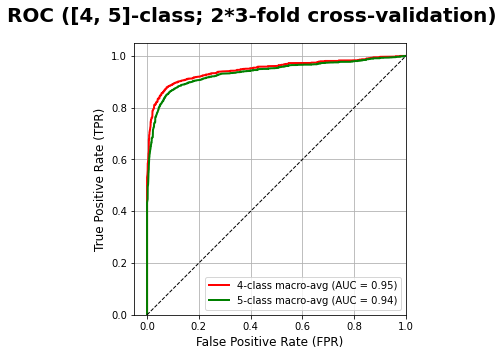

In [39]:
fprIdx, tprIdx, aucIdx = 0, 1, 2
classNbList = list(classNb.keys())
fig, ax = plt.subplots(1, 1, figsize=(20,5))
fig.suptitle('ROC ({}-class; {}*{}-fold cross-validation)'.format(str(classNbList), n_repeats, n_splits), #  performance evaluation technique
            fontsize=20, fontweight='bold')  
for i in range(len(fpr_models)):
    ax.plot(fpr_models[i][fprIdx]["macro"], fpr_models[i][tprIdx]["macro"], colors_classes[i], lw=lw, 
                   label='{0}-class macro-avg (AUC = {1:0.2f})'.format(classNbList[i], fpr_models[i][aucIdx]["macro"]))        
rocAxis_plotter(ax, lw, 'True Positive Rate (TPR)')

# Confusion matrix

In [40]:
# fpr_models

In [62]:
test_size = 0.25


def confusionMatrix_plotter(ax, cf_matrix, classLabel, classLabelTot, origNew, ylabel=None):
# Compute and plot the Confusion matrix
    
#     if cf_dim == 2:
#         categories  = ['Negative', "Positive"]
#         group_names = ['TN','FP',"FN", 'TP']
#     elif cf_dim == 3:
#         categories  = ['Negative',"Neutral",'Positive']
#         group_names = ['Correct','Wrong',"Wrong", 'Wrong','Correct',"Wrong",'Wrong','Wrong',"Correct"]
    cf_dim = len(cf_matrix)
    categories  = ['b']*cf_dim
    group_names = ['b']*(cf_dim**2)
        
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.ravel() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(cf_dim, cf_dim)

    if cf_dim == 2:
        cmap = colors_classes_CF[i]
    else: # cf_dim == n_classes:
        cmap = 'Greys'
    h = sns.heatmap(cf_matrix, ax=ax, annot = labels, cmap = cmap,fmt = '',
                xticklabels = categories, yticklabels = categories)
    ax.set_ylim(cf_dim, 0)
    ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')
    
    if cf_dim == 2:
        tn, fp, fn, tp = cf_matrix.ravel()
        tpr = tp / (tp + fn)
        ppv = tp / (tp + fp)    
        acc = (tp + tn) / (tp + tn + fn + fp)
    else: # cf_dim == n_classes:
        acc = np.sum(np.diag(cf_matrix)) / np.sum(cf_matrix)
        tpr = np.nan
        ppv = np.nan 
        
    ax.set_xlabel("Predicted values", fontdict = {'size':12}) #, labelpad = 10
    ax.set_ylabel(ylabel, fontdict = {'size':12}) # , labelpad = 10     
        
    if classLabel != None: # Binary
        theRestTot = negClass_finder(classLabel, classLabelTot, origNew)
        ax.set_title ("Pos. label : {0}\nNeg. labels : {1}\nTPR={2:.2%}, PPV={3:.2%}\nACC={4:.2%}".
                      format(origNew[classLabel], theRestTot,tpr, ppv, acc), 
                                    fontdict = {'size':12}) # , pad = 20
    else: # Multiclass
        ax.set_title ("Multi-class task\nAcc={0:.2%}".format(acc), fontdict = {'size':12})
    
#     return (tpr, ppv, acc)


# def model_fit_total(ax, X_train, X_test, y_train, y_test, classifier, threshold, cf_dim):
#     if cf_dim == 2:
#         y_score = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1] # decision_function
#         y_score[y_score >= threshold] = 1
#         y_score[y_score < threshold] = 0
#     else: #elif cf_dim == 3:
#         y_score = classifier.fit(X_train, y_train).predict(X_test)
    
#     cf_matrix = confusion_matrix(y_test, y_score)
#     tpr, ppv, acc = confusionMatrix_plotter(ax, cf_matrix, cf_dim) 
#     return (tpr, ppv, acc)

def split_feature_clf_confusion(X, y, test_size, clf, thr):
    """Splits into train/test; extracts features; trains & tests the classifier. Returns average test confusion matrix."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) # train/test split
    model, _ = model_builder(y_train, clf, '')
    model.fit(X_train, y_train)                 
    if len(np.unique(y)) == 2: # If binary task  
        y_score = model.predict_proba(X_test)[:, 1]
        y_score[y_score >= thr] = 1
        y_score[y_score < thr] = 0
    else:
        y_score = model.predict(X_test)
    return confusion_matrix(y_test, y_score)

In [49]:
# fpr_models[0][1]

# Visualisation

In [53]:
# A = confusion_matrix([0,1, 2], [0, 1, 2])
# len(A)

3

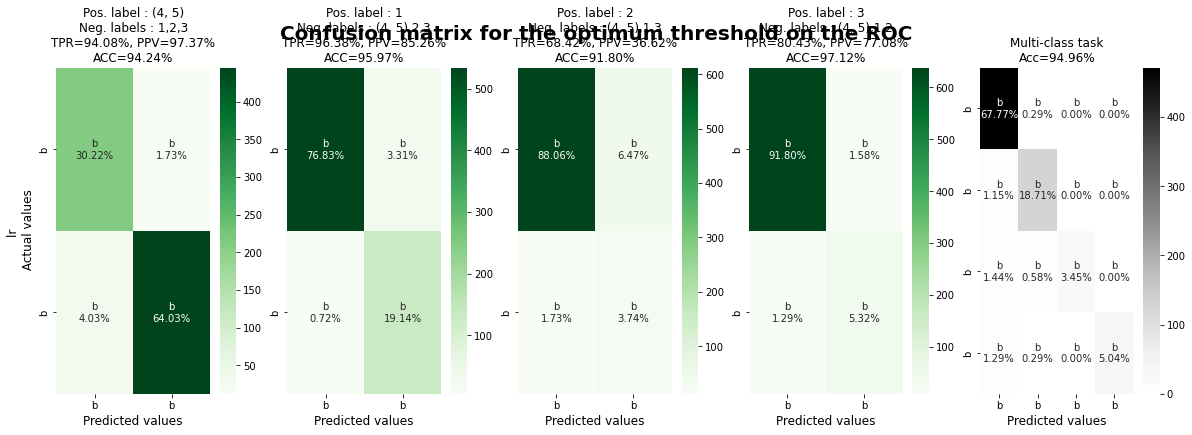

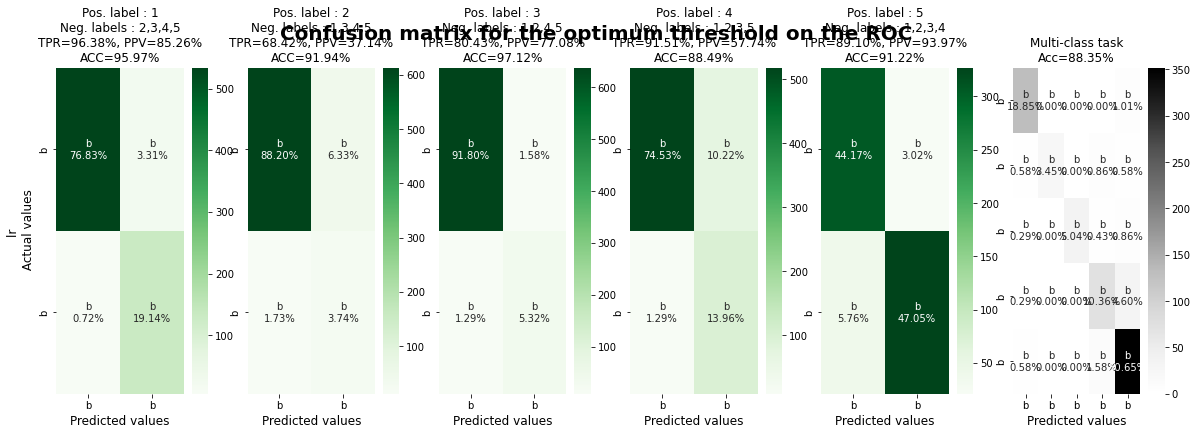

In [63]:
# def confusionTot_plotter(model_name, clf):
def confusionTot_plotter(fpr_model, optDataCleanedMerged, reviewColName, ratingColName, ratingOrigColName, clfName, clf):
    YOrig = optDataCleanedMerged[ratingOrigColName].values
    Xtxt = optDataCleanedMerged[reviewColName].values
    Ytxt = optDataCleanedMerged[ratingColName].values
    origNew = origNewLabel_finder(YOrig, Ytxt)
    classLabelTot = list(np.unique(Ytxt))    
    X_binary, Y_binary = output_binariser(Xtxt, Ytxt, classLabelTot)
    n_classes = len(classLabelTot)
    
    clf = OneVsRestClassifier(clf)
    # fig, ax = plt.subplots(n_models, n_classes+1, figsize=(20,6*(n_models))) # , sharey=True, sharex=True
    fig, ax = plt.subplots(1, n_classes+1, figsize=(20,6)) # , sharey=True, sharex=True
    fig.suptitle('Confusion matrix for the optimum threshold on the ROC', fontsize=20, fontweight='bold') 
    # X_trainOrig, X_testOrig, y_train, y_test = train_test_split(XSmote, YSmote, test_size = test_size, random_state=random_state)
#     X_trainOrig, X_testOrig, y_train, y_test = train_test_split(Xtxt, Ytxt, test_size = test_size, random_state=random_state)
#     vector = TfidfVectorizer(sublinear_tf=True)
#     X_trainOrig = vector.fit_transform(X_trainOrig)
#     X_testOrig = vector.transform(X_testOrig)

    # smote = SMOTE(random_state=random_state, sampling_strategy={-1:equalClassSize, 0:equalClassSize, 1:equalClassSize}) # 
    # X_trainOrig, y_train = smote.fit_resample(X_trainOrig, y_train)
    # X_testOrig, y_test = smote.fit_resample(X_testOrig, y_test)

#     for i in range(n_classes):
    for i, classLabel in enumerate(classLabelTot):
#         X_train, X_test, y_binary_train, y_binary_test = train_test_split(X_binary[i], Y_binary[i], test_size=test_size, random_state=random_state)

#         vector = TfidfVectorizer(sublinear_tf=True)
#         X_train = vector.fit_transform(X_train)
#         X_test = vector.transform(X_test)

    #     smote = SMOTE(random_state=random_state, sampling_strategy={0:equalClassSize, 1:equalClassSize}) # 
    #     X_train, y_binary_train = smote.fit_resample(X_train, y_binary_train)
    #     X_test, y_binary_test = smote.fit_resample(X_test, y_binary_test)

#         for k, (model_name, classifier) in enumerate(models.items()):
        thr = fpr_model[aucIdx]["macro_{}BestThrVal".format(i+1)]
#         cf_dim = 2

#         tpr, ppv, acc = model_fit_total(ax[k, i], X_train, X_test, y_binary_train[:, i], y_binary_test[:, i], classifier, threshold, cf_dim)
#         tpr, ppv, acc = model_fit_total(ax[i], X_train, X_test, y_binary_train, y_binary_test, classifier, threshold, cf_dim)
        
        cfMatrix = split_feature_clf_confusion(X_binary[i], Y_binary[i], test_size, clf, thr)
        if i == 0:
            ylabel = "{} \n Actual values".format(clfName)
        else:
           ylabel = None 
        confusionMatrix_plotter(ax[i], cfMatrix, classLabel, classLabelTot, origNew, ylabel) 
#         if k == n_models - 1:
#             ax[i].set_xlabel("Predicted values", fontdict = {'size':12}) #, labelpad = 10
#         ax[i].set_xlabel("Predicted values", fontdict = {'size':12}) #, labelpad = 10
#         if i == 0:
#             ax[i].set_ylabel("{} \n Actual values".format(model_name), fontdict = {'size':12}) # , labelpad = 10       
#         if k == 0:    
#             theRest = classLabel.copy()
#             theRest.pop(i)
#             ax[i].set_title ("Binary task (OvR)\nPositive class label : {0:d}\nNegative class labels : {1:d}, {2:d}\nTPR={3:.2%}, PPV={4:.2%} \n ACC={5:.2%}".format(classLabel[i], theRest[0], theRest[1],tpr, ppv, acc), 
#                                 fontdict = {'size':12}) # , pad = 20
#         else:
#             ax[i].set_title ("TPR={0:.2%}, PPV={1:.2%} \n ACC={2:.2%}".format(tpr, ppv, acc), 
#                                 fontdict = {'size':12}) # , pad = 20
#         theRest = classLabel.copy()
#         theRest.pop(i)
#         ax[i].set_title ("Pos. label : {0:d}\nNeg. labels : {1:d}, {2:d}\nTPR={3:.2%}, PPV={4:.2%} \n ACC={5:.2%}".format(classLabel[i], theRest[0], theRest[1],tpr, ppv, acc), 
#                                 fontdict = {'size':12}) # , pad = 20


# #     for k, (model_name, classifier) in enumerate(models.items()):              
#     threshold = fpr_models[aucIdx]["macroBestThrVal"]
# #     cf_dim = len(np.unique(y_train))

#     tpr, ppv, acc = model_fit_total(ax[n_classes], X_trainOrig, X_testOrig, y_train, y_test, classifier, [], cf_dim)

# #         if k == n_models - 1:
# #             ax[n_classes].set_xlabel("Predicted values", fontdict = {'size':12}) #, labelpad = 10
#     ax[n_classes].set_xlabel("Predicted values", fontdict = {'size':12}) #, labelpad = 10
# #         if k == 0:
# #             ax[n_classes].set_title ("Multi-class task\nAcc={0:.2%}".format(acc), fontdict = {'size':12}) # , pad = 20
# #         else:
# #             ax[n_classes].set_title ("Acc={0:.2%}".format(acc), fontdict = {'size':12})
#     ax[n_classes].set_title ("Multi-class task\nAcc={0:.2%}".format(acc), fontdict = {'size':12}) # , pad = 20
    
    thr = fpr_model[aucIdx]["macroBestThrVal"]
    cfMatrix = split_feature_clf_confusion(Xtxt, Ytxt, test_size, clf, thr)
    confusionMatrix_plotter(ax[n_classes], cfMatrix, None, None, None, None) 
        
    plt.savefig("../working/{}-confusion.png".format(n_classes))
    
# for clfName, clf in zip(optClfName, optClf):
#     confusionTot_plotter(clfName, clf)

for fpr_model, dataCleanedMergedTmp, classTmp, clfName, clf in zip(fpr_models, optDataCleanedMerged, optClass, optClfName, optClf):
    confusionTot_plotter(fpr_model, dataCleanedMergedTmp, reviewColName, ratingColName, ratingOrigColName, clfName, clf)
